In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from zipfile import ZipFile
from scipy import stats
from IPython.display import display
pd.options.display.max_columns = None
import warnings 
warnings.filterwarnings('ignore')

# Time Series & Forecasting

## Exercise 1: 

`data/babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as its own time series 

1. Combine all of the files within the `babies.zip` file into one **DataFrame**
2. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John` (*difference* as needed)
3. Pick any **3** names of your choice and using **3** different ARIMA models, forecast the frequencies for each these names for the next **2** years. Provide brief interpretations of your results
**NOTE:** You are expected to use visualizations/data exploration, split your data into training & testing sets, evaluate your model, and then predict into the unknown

In [2]:
# exercise 1
# pull the files from zip and concatenate them with the file name year as a column excluding that pdf at the end
df = pd.concat(
    [pd.read_csv(ZipFile("../data/babies.zip").open(i), header=None, names=['name', 'sex', 'Counts'], ).assign(year=i[3:7])
     for i in ZipFile("../data/babies.zip").namelist()[:-1]],
    ignore_index=True
)
df.sample(6)

,name,sex,Counts,year
1832808,Ellodie,F,6,2015
1242039,Star,F,221,1997
1171755,Jaysa,F,9,1994
1564741,Paitynn,F,5,2007
40847,Haskell,M,6,1898
568624,Latrice,F,10,1960


In [3]:
# many names are unisex and we are more interested in the names so will combine the sexes
df.value_counts(['name','year']).sort_values(ascending=False).to_frame().head(10)

0
name   year   
Sol    1977  2
Norma  1936  2
Evelyn 1922  2
Norma  1927  2
       1926  2
       1925  2
       1924  2
       1923  2
       1922  2
Amparo 1986  2

In [4]:
# create a new data frame with multi-indexing
df_ = df.copy()
df_.year = pd.to_datetime(df.year, format='%Y')
df_.sort_values(by='year', ascending=True, inplace=True)
df_.set_index('name', inplace=True)
df_.set_index('sex', inplace=True, append=True)
df_.set_index('year', inplace=True, append=True)
df_.sample(5)

,,,Counts
name,sex,year,
Karri,F,1965-01-01,85
Luisangel,M,1993-01-01,11
Kamrie,F,2012-01-01,15
Tylan,M,1979-01-01,12
Fausto,M,1939-01-01,11


In [5]:
# combine counts for sexes on name and year
df_group = df_.groupby(level=['name','year']).sum()
df_group.sample(5)

,,Counts
name,year,
Harlie,2002-01-01,122
Seneca,2007-01-01,81
Koleen,1976-01-01,6
Kaedan,2014-01-01,12
Midge,1940-01-01,21


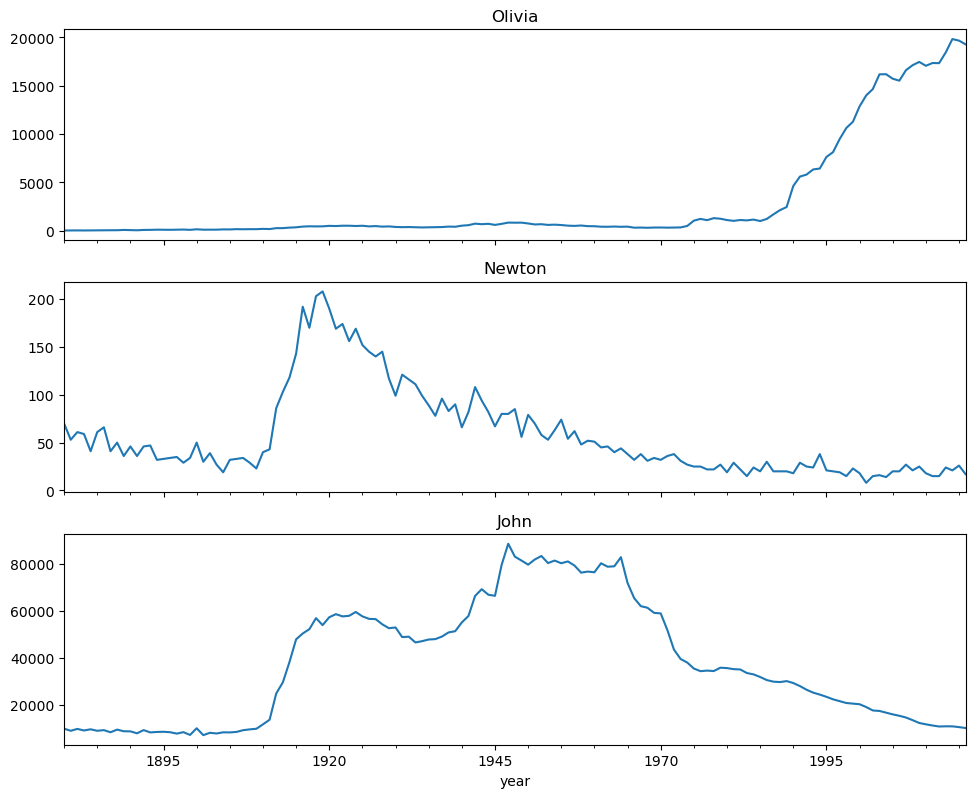

In [6]:
# plot Olivia, Newton, and John to get a sense of trends
fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,8))
plt.tight_layout(pad=2)

df_group.loc['Olivia']['Counts'].plot(ax=axs[0], title='Olivia')
df_group.loc['Newton']['Counts'].plot(ax=axs[1], title='Newton')
df_group.loc['John']['Counts'].plot(ax=axs[2], title='John')
plt.show()

# there does not seem to be 'seasonality' with these names

In [7]:
# get the difference number that results in significance for ADF and KPSS and return differenced timeseries
def get_stationary(name, p=0.05):
    timeseries = df_group.loc[name]['Counts']
    dif_n=1
    diff_timeseries = diff(timeseries,k_diff=dif_n)
    while (kpss(diff_timeseries)[1] < p) or (adfuller(diff_timeseries)[1] > p):
        dif_n += 1
        diff_timeseries = diff(timeseries,k_diff=dif_n)
    print(f'Difference {name} {dif_n} times for ADF and KPSS significant stationary.')
    return diff_timeseries
    

In [8]:
# create the differenced tables for use in ACF and PACF
olivia_stationary = get_stationary('Olivia')
newton_stationary = get_stationary('Newton')
john_stationary = get_stationary('John')

Difference Olivia 3 times for ADF and KPSS significant stationary.
Difference Newton 1 times for ADF and KPSS significant stationary.
Difference John 2 times for ADF and KPSS significant stationary.


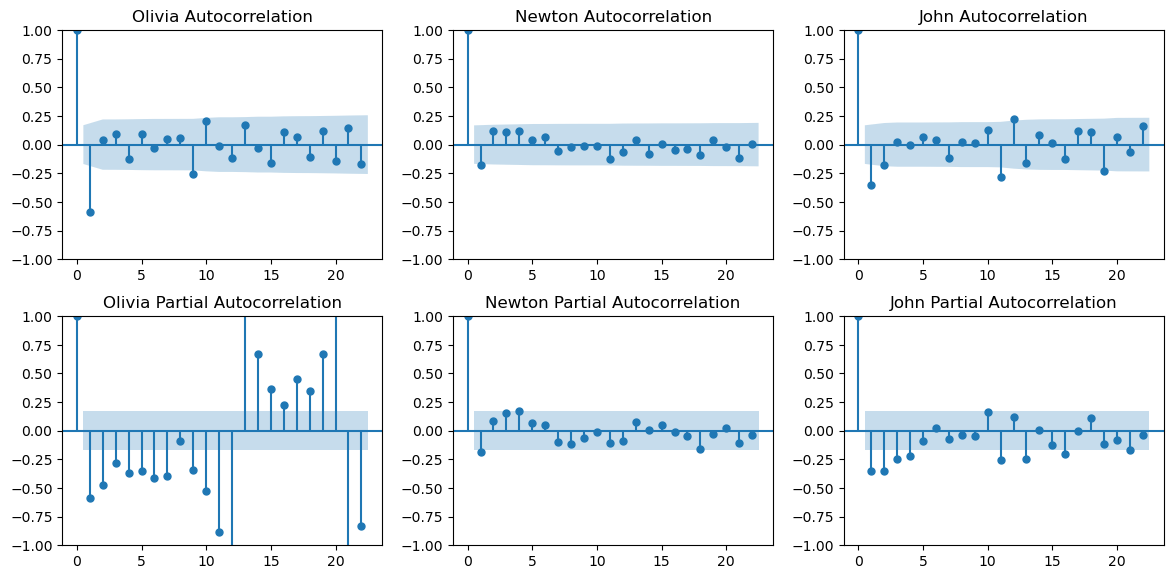

In [9]:
fig, axs = plt.subplots(2,3, figsize=(12,6))
plt.tight_layout(pad=2)

plot_acf(olivia_stationary, ax=axs[0,0], title='Olivia Autocorrelation')
plot_pacf(olivia_stationary, ax=axs[1,0], title='Olivia Partial Autocorrelation')
plot_acf(newton_stationary, ax=axs[0,1], title='Newton Autocorrelation')
plot_pacf(newton_stationary, ax=axs[1,1], title='Newton Partial Autocorrelation')
plot_acf(john_stationary, ax=axs[0,2], title='John Autocorrelation')
plot_pacf(john_stationary, ax=axs[1,2], title='John Partial Autocorrelation')
plt.show()

Olivia auto ARIMA: (0, 2, 2)
Newton auto ARIMA: (2, 1, 2)
John auto ARIMA: (0, 2, 2)


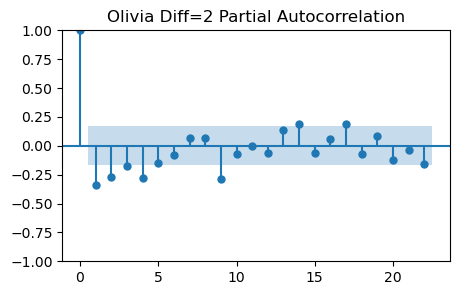

In [10]:
# out of curiosity, what are the auto arima difference values for each name
olivia_auto = auto_arima(df_group.loc['Olivia'][['Counts']], seasonal=False, max_d=4)
newton_auto = auto_arima(df_group.loc['Newton'][['Counts']], seasonal=False, max_d=4)
john_auto = auto_arima(df_group.loc['John'][['Counts']], seasonal=False, max_d=4)
print(f'Olivia auto ARIMA: {olivia_auto.get_params()["order"]}')
print(f'Newton auto ARIMA: {newton_auto.get_params()["order"]}')
print(f'John auto ARIMA: {john_auto.get_params()["order"]}')
fig, ax = plt.subplots(figsize=(5,3))
plot_pacf(diff(df_group.loc['Olivia']['Counts'],k_diff=2), title='Olivia Diff=2 Partial Autocorrelation', ax=ax)
plt.show()

#### Discussion
- Partial autocorrelation for Olivia is quite erratic after diff of 3, but that order of differencing is needed to satisfy both ADF and KPSS p values. The graphs are all difficult to interpret for determining <b>p</b> and <b>q</b> values but the auto ARIMA values make sense since usually if PACF is more variable it will result in a higher <b>q</b> and if ACF and PACF variability are the same <b>p</b> and <b>q</b> will also be the same, based on my understanding. Also, seeing the auto ARIMA <b>d</b> for Olivia is 2, plotting the PACF for that differencing shows a more balanced partial autocorrelation so it's a good indicator that choosing to use both ADF and KPSS can sometimes lead to over differencing.

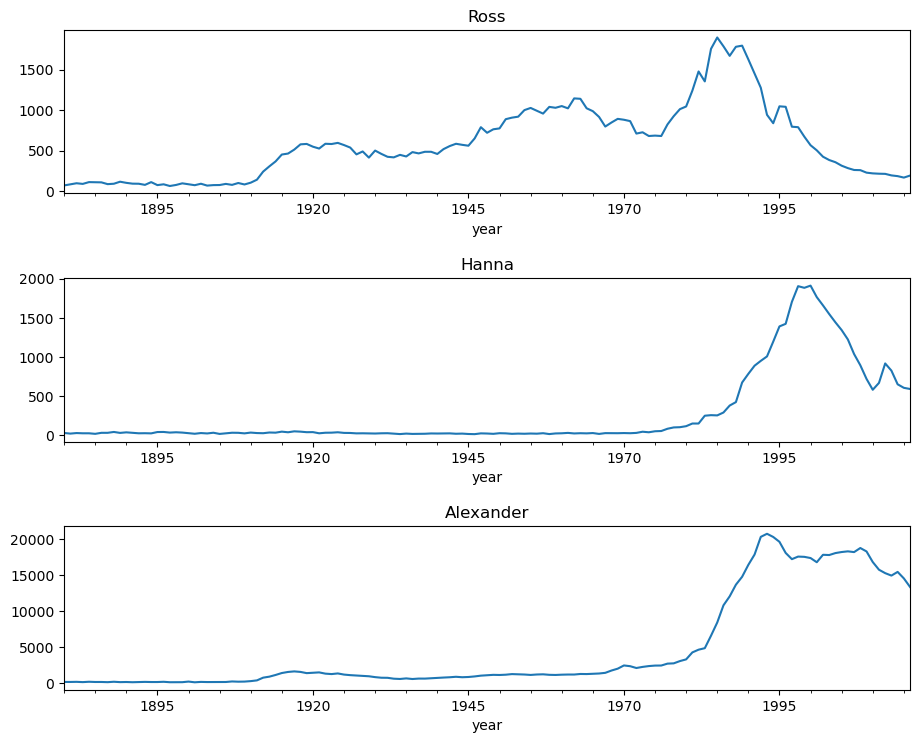

In [11]:
# plot the names to forecast
fig, axs = plt.subplots(3,1, figsize=(10,8))
plt.tight_layout(pad=4)

# names to investigate
name1 = 'Ross'
name2 = 'Hanna'
name3 = 'Alexander'

df_group.loc[name1]['Counts'].plot(ax=axs[0], title=name1)
df_group.loc[name2]['Counts'].plot(ax=axs[1], title=name2)
df_group.loc[name3]['Counts'].plot(ax=axs[2], title=name3)
plt.show()

In [12]:
# easily test models and plots based on name, and number of test and train years and get info
def predict_plot_name(df, name, test_years, train_years=None):
    # for testing number of years to train on if not the whole train series
    if train_years is not None:
        train_years = -(train_years + test_years)
    
    # get the train and test sets based on test and train years
    train = df.loc[name].iloc[train_years:-test_years]
    test = df.loc[name].iloc[-test_years:]
    
    # perform auto arima to get orders and store in variables
    arima = auto_arima(train, max_d=3)
    order = arima.get_params()['order']
    
    # get the model to make predictions on using the order found above then predict
    model = ARIMA(train, order=order).fit()
    prediction = model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

    print(model.summary()) # show the model for reference
    
    # metrics to assess quality of model
    print('\n-----------------')
    print(f'RMSE: {rmse(test.Counts, prediction):.2f}')
    print(f'Test mean: {test.Counts.mean():.2f}')
    print(f'Prediction mean: {prediction.mean():.2f}')
    print('-----------------')
    
    # create the plot with predicted and actual to compare
    test.plot(figsize=(10,4), legend=True) # actual
    prediction.plot(legend=True) # predicted
    plt.legend(['Counts',f'ARIMA {order}']) # legend names
    max_y = max([prediction.values.max(), test.values.max()]) # max y value in the plotted range
    plt.ylim(0,max_y+0.4*max_y) # add 40% above the max y value
    plt.title(f'Predicted vs Actual Counts/Year for "{name}"')
    plt.grid()
    plt.show()
    
    return model # return the model to retrieve info

# quickly plot forecasts for any name after getting the appropriate order from the model
def forecast_plot(model, df, name, years=2, years_back=15):
    series = df.loc[name]
    order = model.model.order
    
    model = ARIMA(series, order=order).fit()

    forecast = model.predict(start=len(series), end=len(series)+years-1, typ='levels').rename('ARIMA Forecast')
    
    series.plot(legend=True,figsize=(10,4))
    forecast.plot(legend=True)
    max_y = max([forecast.values.max(), series.iloc[-years_back:].values.max()]) # max y value in the plotted range
    plt.ylim(0,max_y+0.4*max_y) # add 40% above the max y value
    plt.xlim(series.index[-years_back], forecast.index[-1]) # close up on the years before the forecast
    plt.title(f'{years} Year Forecast for Counts of "{name}" : ARIMA {order}')
    plt.grid()
    plt.show()
    
    print('Forecast Values:')
    print(forecast)
    

                               SARIMAX Results                                
Dep. Variable:                 Counts   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -590.241
Date:                Sun, 26 Mar 2023   AIC                           1186.482
Time:                        18:53:17   BIC                           1194.268
Sample:                    01-01-1907   HQIC                          1189.632
                         - 01-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8101      0.117      6.943      0.000       0.581       1.039
ma.L1         -0.6376      0.156     -4.078      0.000      -0.944      -0.331
sigma2      8820.5834    826.451     10.673      0.0

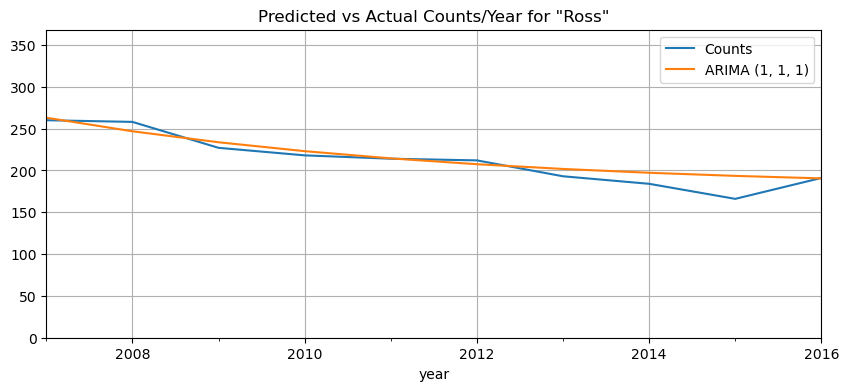

In [13]:
# 10 year test range with 100 year train range gave a good RMSE
name1_model = predict_plot_name(df_group, name1, 10, 100)

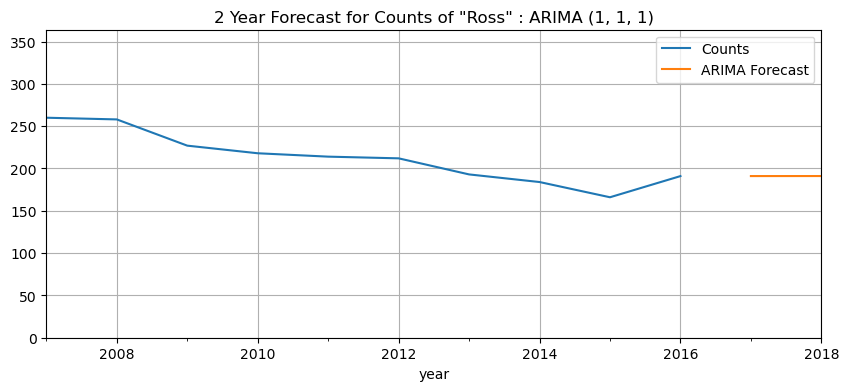

Forecast Values:
2017-01-01    191.044119
2018-01-01    191.079868
Freq: AS-JAN, Name: ARIMA Forecast, dtype: float64


In [14]:
forecast_plot(name1_model, df_group, name1, 2, 10)

#### Interpretation

- An ARIMA (1,1,1) model seems to be the best for minimizing RMSE with the predicted and test means being very similar. The forecast is very flat indicating that the model is converging on the mean very quickly so there is not much predictive value to this model. The p values are all significant for this model indicating a good fit though.

                               SARIMAX Results                                
Dep. Variable:                 Counts   No. Observations:                   40
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -235.790
Date:                Sun, 26 Mar 2023   AIC                            475.581
Time:                        18:53:18   BIC                            478.908
Sample:                    01-01-1975   HQIC                           476.774
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5797      0.128      4.521      0.000       0.328       0.831
sigma2      1.034e+04   2097.198      4.929      0.000    6227.237    1.44e+04
Ljung-Box (L1) (Q):                   0.00   Jarque-

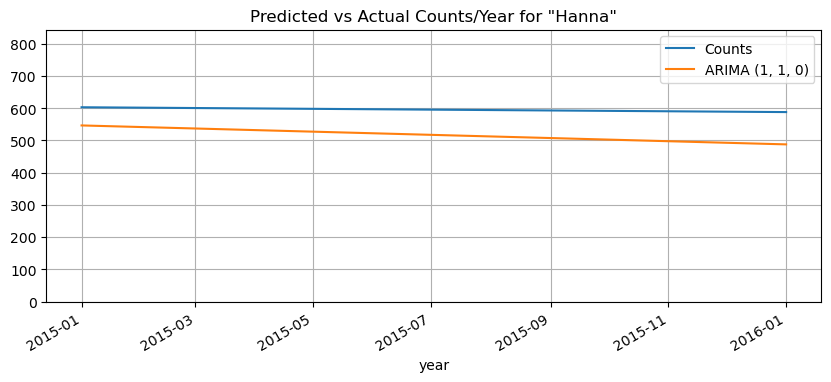

In [15]:
# 2 year test range with 40 year train range gave the best RMSE even though it's still not great
name2_model = predict_plot_name(df_group, name2, 2, 40)

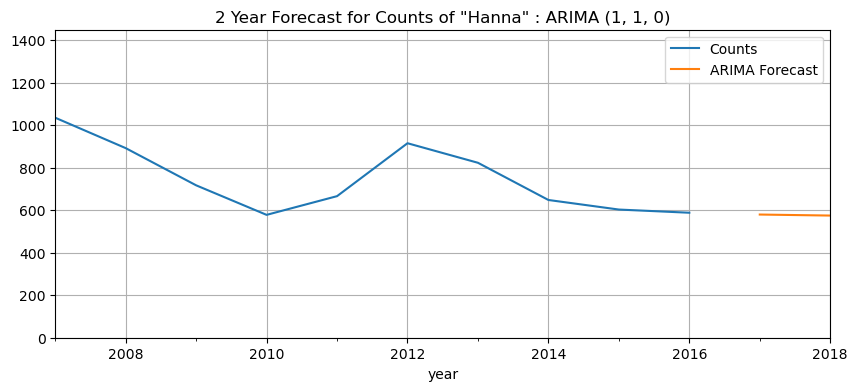

Forecast Values:
2017-01-01    579.510892
2018-01-01    574.706561
Freq: AS-JAN, Name: ARIMA Forecast, dtype: float64


In [16]:
forecast_plot(name2_model, df_group, name2, 2, 10)

#### Interpretation

- The model is not excellent with a an RMSE that is fairly high compared to the means. This is probably because this name has a lower count and a more erratic trend with a bump in 2012. The ARIMA order is also quite simple with only 1 differencing and <b>p</b> of 1. When it is just an AR model, the coefficient explains how quickly the model will converge towards the mean. In this case, a coefficient of 0.58 will converge to the mean after only a few years. The predicted values for the next two years are very close, similar to the previous name.

                               SARIMAX Results                                
Dep. Variable:                 Counts   No. Observations:                  132
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -963.959
Date:                Sun, 26 Mar 2023   AIC                           1935.918
Time:                        18:53:21   BIC                           1947.419
Sample:                    01-01-1880   HQIC                          1940.591
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2058      0.068     -3.022      0.003      -0.339      -0.072
ar.L2          0.7131      0.060     11.792      0.000       0.595       0.832
ma.L1          0.8881      0.089      9.974      0.0

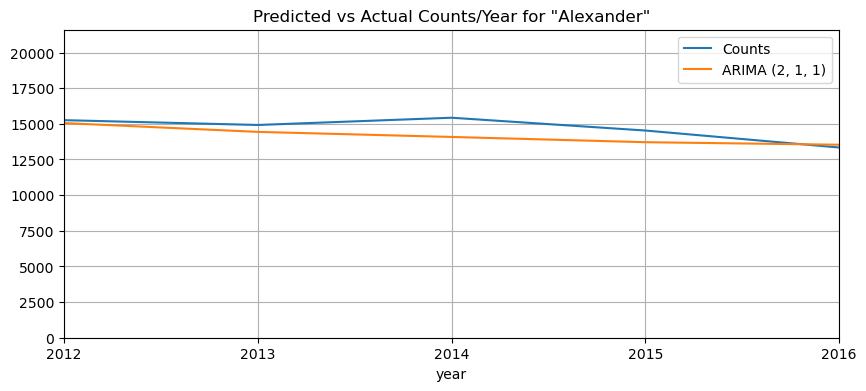

In [17]:
# a 5 year test range with the rest of the data as training gave good results for this model
name3_model = predict_plot_name(df_group, name3, 5)

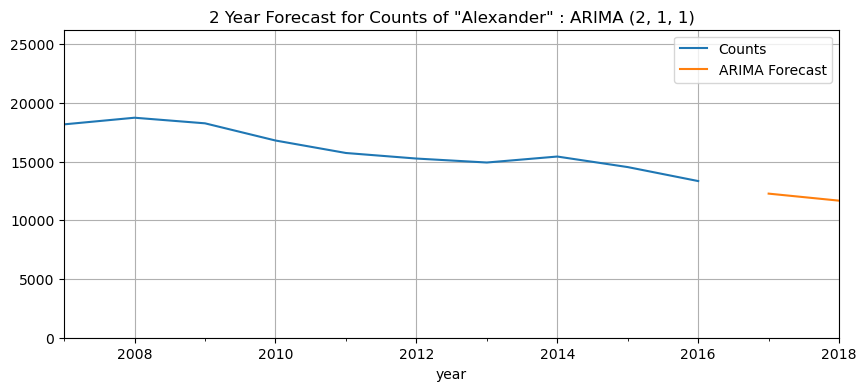

Forecast Values:
2017-01-01    12268.929682
2018-01-01    11670.103334
Freq: AS-JAN, Name: ARIMA Forecast, dtype: float64


In [18]:
forecast_plot(name3_model, df_group, name3, 2, 10)

#### Interpretation

- This model is more interesting as it at least shows some kind of trend. The forecast is that there will be fewer Alexanders in 2017 and 2018. The ARIMA summary shows that all p values are significant. The RMSE is large but a smaller proportion of means than the previous name. With a second order AR model the effect of the coefficients for AR components can be somewhat understood by the equation <a href= https://stats.stackexchange.com/questions/40905/arima-model-interpretation>$\alpha_1^2 + 4\alpha_2$</a>, where if this is less than zero the forecast will have some perodic behavior but if greater than zero will be more similar to an AR 1 model. The case here is greater than zero so not periodic. 

## Exercise 2: 

Using ARIMA-based models and the `HospitalityEmployees.csv` file, forecast the number of *Hospitality Employees* **1** year into the future. Provide an interpretation of your findings

**Note:** Make sure to perform the necessary exploratory steps as well as to visualize your data & evaluate your results. 

In [19]:
# exercise 2
emp_df = pd.read_csv('../data/HospitalityEmployees.csv')
emp_df.head()

,Date,Employees
0,1/1/1990,1064.5
1,2/1/1990,1074.5
2,3/1/1990,1090.0
3,4/1/1990,1097.4
4,5/1/1990,1108.7


In [20]:
# set up timeseries
emp_df.Date = pd.to_datetime(emp_df.Date, format='%m/%d/%Y')
emp_ts = emp_df.set_index('Date')
emp_ts.index.freq = 'MS'
emp_ts.sample(5)

,Employees
Date,
1996-04-01,1215.3
2003-09-01,1419.6
2004-09-01,1462.0
2018-09-01,1992.5
2004-01-01,1381.7


<AxesSubplot:xlabel='Date'>

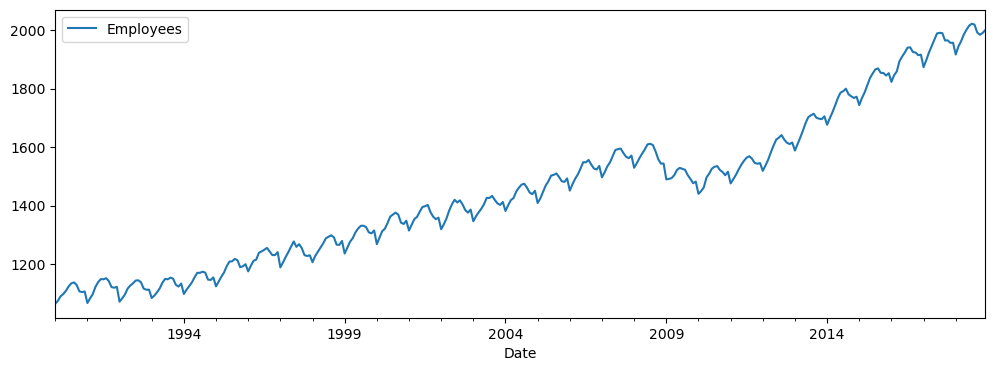

In [21]:
emp_ts.plot(figsize=(12,4))
# clear seasonal trend that will need to be accounted for

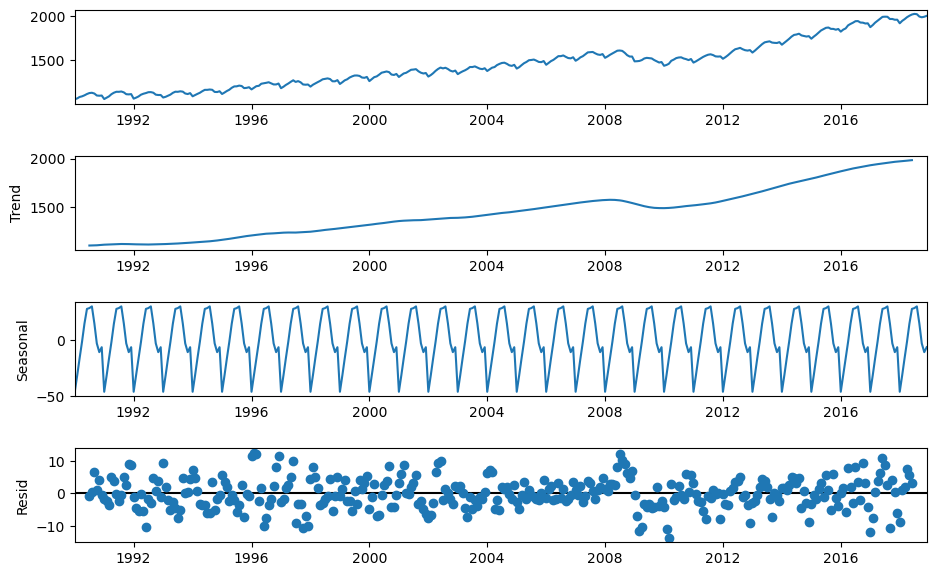

In [22]:
fig = seasonal_decompose(emp_ts).plot()
fig.set_figwidth(10)
fig.set_figheight(6)
plt.show()
# seasonal decompose confirms seasonality, resid shows some heteroskedasticity

<AxesSubplot:xlabel='Date'>

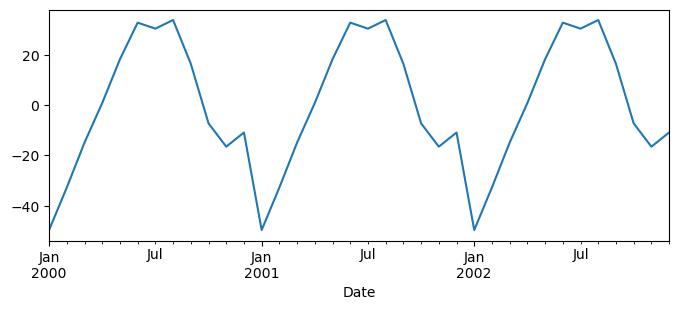

In [23]:
seasonal_decompose(emp_ts.loc['2000':'2002']).seasonal.plot(figsize=(8,3))
# confirm M of 12

In [24]:
# perform auto_arima on full dataset to get the appropriate orders to use in the final model
arima = auto_arima(emp_ts, seasonal=True, m=12)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Sun, 26 Mar 2023   AIC                           2208.504
Time:                                      18:54:11   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9248      0.045     20.613      0.000       0.837       1.013
ma.L1         -0.9443      0.070    -13.542      0.000      -1.081      -0.808
ma.L2          0.1286      0.060      2.146      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    704.926      0.000       0.994       1.000
ma.S.L12      -0.7491      0.043    -17.348      0.000      -0.834      -0.665
sigma2        29.3011      1.718     17.054      0.000      25.934      32.669
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# train test split for SARIMA model and prediction
n_months = 12

train = emp_ts.iloc[:-n_months]
test = emp_ts.iloc[-n_months:]

In [26]:
# using the orders from the model above do a fit of the train data and get the prediction
sarima_fit = SARIMAX(train, order=arima.order, seasonal_order=arima.seasonal_order).fit()
predict = sarima_fit.predict(start=len(train), end=len(emp_ts)-1, typ='levels')

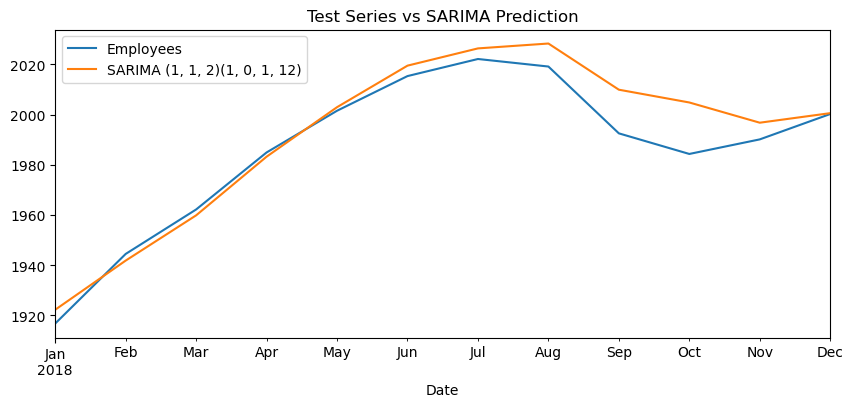


-----------------
RMSE: 8.82
Test mean: 1986.12
Prediction mean: 1991.34
-----------------


In [27]:
# plot to confirm that the model is working well against the test data
test.plot(legend=True,figsize=(10,4))
predict.plot(legend=True)
plt.legend(['Employees', f'SARIMA {arima.order}{arima.seasonal_order}'])
plt.title('Test Series vs SARIMA Prediction')
plt.show()

# metrics to assess quality of model
print('\n-----------------')
print(f'RMSE: {rmse(test.Employees, predict):.2f}')
print(f'Test mean: {test.Employees.mean():.2f}')
print(f'Prediction mean: {predict.mean():.2f}')
print('-----------------')

- The model looks good for both the graph and the RMSE. The means are very close and the error is quite small compared to the means. The SARIMA model also has significant p values for all coefficients but the heteroskedasticity test confirms that the variance seen in the residual plot is significant which might impact prediction reliabilty.

In [28]:
# get the forecast by fitting to whole dataset and predicting into the future
sarima_fit_f = SARIMAX(emp_ts, order=arima.order, seasonal_order=arima.seasonal_order).fit()
forecast = sarima_fit.predict(start=len(emp_ts), end=len(emp_ts)+n_months-1, typ='levels')

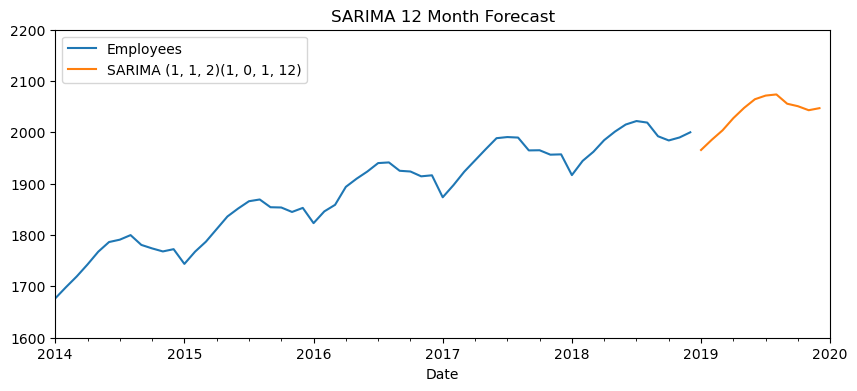

In [29]:
emp_ts.plot(legend=True,figsize=(10,4))
forecast.plot(legend=True)
plt.legend(['Employees', f'SARIMA {arima.order}{arima.seasonal_order}'], loc='upper left')
plt.title(f'SARIMA {n_months} Month Forecast')
plt.xlim('2014', '2020')
plt.ylim(1600, 2200)
plt.show()

- The forecast seems appropriate as it follows the trend and maintains the seasonality of the previous years. 